This feature selection notebook does a filter followed by a wrapper for a binary dependent variable (binary classification). It's capable of doing the filter on more than one file. The variable files are called vars1.csv, vars2.csv ... 

The filter runs separately on each vars file and keeps the top num_filter variables from each file. If there are more than one vars files we'll again select the top num_filter variables across all the vars.csv files.

If balance = 0 the entire files are used. If balance != 0 then balance is the RATIO OF BADS TO GOODS retained for the rest of the feature selection. We keep all the rare class (bads) and downsample the goods. I think in general it's better to keep balance = 0.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
%matplotlib inline
start_time = dt.datetime.now()

In [2]:
# set some parameters
num_files = 1
# I recommend set num_filter to be about 10 to 20% of the original # variables
num_filter = 200
# I recommend set num_wrapper to be about 50, then look for a saturation of the model performance as variables are added
# Then you can run it again with num_wrapper just a bit above this saturation point, not more than about twice this saturation number
num_wrapper = 20
balance = 0
detect_rate = .03
index_name = 'Recnum'
y_name = 'Fraud'
good_label = 0
bad_label = 1

## Run a filter on all the files

In [3]:
%%time
filter_score_df_list = []
for i in range(num_files):
#     file_name = "vars"+str(i+1)+'.csv'
    file_name = 'candidate_variables_smaller.csv'
    df = pd.read_csv(file_name)
    print("********** working on",file_name,"size is",df.shape)
    df = df.set_index(index_name) 
    df = df[df.index <= 85264] # remove the last two months as the out-of-time data (OOT)
    df = df[df.index >= 3466] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            goods = goods.loc[goods_keep] 
            
    df_sampled = pd.concat([goods,bads])
    df_sampled.sort_index(inplace=True)
    filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
    filter_score.columns = ['variable','filter score']   
    j = 0
    for column in df_sampled:
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'filter score'] = sps.ks_2samp(goods[column],bads[column])[0]
        j = j+1
        if j%100 == 0:
            print(j)

    filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
    vars_keep = list(filter_score['variable'][1:num_filter+1]) 
    print(file_name,filter_score.head(20))
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)

    filter_score_df_list.append(filter_score)
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()
filter_score = pd.concat(filter_score_df_list)

********** working on candidate_variables_smaller.csv size is (97496, 1330)


<timed exec>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Amount' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
candidate_variables_smaller.csv                       variable  filter score
1                        Fraud      1.000000
28             Cardnum_total_3      0.621932
19             Cardnum_total_1      0.619658
10             Cardnum_total_0      0.591318
15             Cardnum_count_1      0.567429
37             Cardnum_total_7      0.564245
24             Cardnum_count_3      0.563356
586           Card_dow_total_7      0.542303
17               Cardnum_max_1      0.532080
33             Cardnum_count_7      0.526897
8                Cardnum_max_0      0.525418
6              Cardnum_count_0      0.516123
595          Card_dow_total_14      0.511203
26               Cardnum_max_3      0.501170
46            Cardnum_total_14      0.494375
584             Card_dow_max_7      0.486177
860      Cardnum_vdratio_1by14      0.485431
904  Cardnum_variability_max_0      0.484245
582           Card_dow_count_7      0.482384
14       Car

In [4]:
filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
filter_score.reset_index(drop=True,inplace=True)

In [5]:
filter_score.head(30)

variable  filter score
0                                   Fraud      1.000000
1                         Cardnum_total_3      0.621932
2                         Cardnum_total_1      0.619658
3                         Cardnum_total_0      0.591318
4                         Cardnum_count_1      0.567429
5                         Cardnum_total_7      0.564245
6                         Cardnum_count_3      0.563356
7                        Card_dow_total_7      0.542303
8                           Cardnum_max_1      0.532080
9                         Cardnum_count_7      0.526897
10                          Cardnum_max_0      0.525418
11                        Cardnum_count_0      0.516123
12                      Card_dow_total_14      0.511203
13                          Cardnum_max_3      0.501170
14                       Cardnum_total_14      0.494375
15                         Card_dow_max_7      0.486177
16                  Cardnum_vdratio_1by14      0.485431
17              Cardnum_variability_max_0      0.484245
18                       Card_dow_count_7      0.482384
19                  Cardnum_actual/toal_0      0.479550
20                 Card_dow_vdratio_0by14      0.479086
21              Cardnum_variability_max_1      0.477836
22  Cardnum_unique_count_for_card_state_1      0.476067
23    Cardnum_unique_count_for_card_zip_1      0.474960
24                      Card_dow_total_30      0.474759
25    Cardnum_unique_count_for_Merchnum_1      0.472017
26                        Card_dow_max_14      0.470975
27                  Card_dow_vdratio_0by7      0.467961
28                   Cardnum_vdratio_1by7      0.466766
29  Cardnum_unique_count_for_card_state_3      0.466410

In [6]:
filter_score.tail(10)

variable  filter score
1320    card_merch_unique_count_for_card_state_30      0.000163
1321    merch_zip_unique_count_for_merch_state_60      0.000138
1322  Card_Merchdesc_unique_count_for_state_des_1      0.000125
1323    card_merch_unique_count_for_card_state_14      0.000100
1324    merch_zip_unique_count_for_merch_state_30      0.000100
1325     card_merch_unique_count_for_card_state_7      0.000088
1326     card_merch_unique_count_for_card_state_3      0.000063
1327    merch_zip_unique_count_for_merch_state_14      0.000025
1328     merch_zip_unique_count_for_merch_state_7      0.000013
1329        card_merch_unique_count_for_Cardnum_1      0.000000

In [7]:
filter_score.shape

(1330, 2)

In [8]:
filter_score.head(80).to_csv('filter_top.csv')
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(i,' vars_keep:',vars_keep)

0  vars_keep: ['Cardnum_total_3', 'Cardnum_total_1', 'Cardnum_total_0', 'Cardnum_count_1', 'Cardnum_total_7', 'Cardnum_count_3', 'Card_dow_total_7', 'Cardnum_max_1', 'Cardnum_count_7', 'Cardnum_max_0', 'Cardnum_count_0', 'Card_dow_total_14', 'Cardnum_max_3', 'Cardnum_total_14', 'Card_dow_max_7', 'Cardnum_vdratio_1by14', 'Cardnum_variability_max_0', 'Card_dow_count_7', 'Cardnum_actual/toal_0', 'Card_dow_vdratio_0by14', 'Cardnum_variability_max_1', 'Cardnum_unique_count_for_card_state_1', 'Cardnum_unique_count_for_card_zip_1', 'Card_dow_total_30', 'Cardnum_unique_count_for_Merchnum_1', 'Card_dow_max_14', 'Card_dow_vdratio_0by7', 'Cardnum_vdratio_1by7', 'Cardnum_unique_count_for_card_state_3', 'Cardnum_unique_count_for_card_zip_3', 'Cardnum_unique_count_for_Merchnum_3', 'Cardnum_actual/toal_1', 'Card_dow_unique_count_for_merch_state_1', 'Card_dow_unique_count_for_Card_Merchdesc_1', 'Card_dow_unique_count_for_state_des_1', 'Card_dow_unique_count_for_merch_zip_1', 'Cardnum_unique_count_for_

In [9]:
vars_keep_df = pd.DataFrame({'col':vars_keep})
vars_keep_df.to_csv('vars_keep_filter.csv',index=False)
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

Cardnum_total_3  Cardnum_total_1  Cardnum_total_0  Cardnum_count_1  \
Recnum                                                                       
3466            1964.73          1551.02           333.47                3   
3467             834.91           660.87             4.37                2   
3468            8459.94          2904.08           271.93                7   
3469             838.53           664.49             7.99                3   
3470              16.28            16.28            16.28                1   

        Cardnum_total_7  Cardnum_count_3  Card_dow_total_7  Cardnum_max_1  \
Recnum                                                                      
3466            3591.53                7            333.47         930.41   
3467             997.73               34            109.97         656.50   
3468            9674.14               14            271.93        1380.45   
3469            1001.35               35            113.59         656.50   
3470              16.28                1             16.28          16.28   

        Cardnum_count_7  Cardnum_max_0  ...  Card_Merchdesc_total_0  \
Recnum                                  ...                           
3466                  9         333.47  ...                  333.47   
3467                 72           4.37  ...                    4.37   
3468                 17         271.93  ...                  271.93   
3469                 73           4.37  ...                    7.99   
3470                  1          16.28  ...                   16.28   

        merch_state_max_0  card_state_vdratio_1by7  Merchnum_max_0  \
Recnum                                                               
3466               333.47                 0.009524          333.47   
3467                 4.37                 0.000671            4.37   
3468               271.93                 0.053571          271.93   
3469                 4.37                 0.003968            4.37   
3470                16.28                 0.000097           16.28   

        merch_zip_max_0  Card_Merchdesc_avg_3  state_des_max_3  \
Recnum                                                           
3466             333.47            333.470000           333.47   
3467               4.37              8.685000            13.00   
3468             271.93            194.313333           278.73   
3469               4.37              6.996667            13.00   
3470              16.28             16.280000           113.87   

        merch_zip_total_7  state_des_max_1  Merchnum_dow_total_7  
Recnum                                                            
3466              4879.97           333.47               2015.83  
3467              1111.49             4.37                190.52  
3468               582.94           278.73                271.93  
3469              1115.11             4.37                194.14  
3470               499.62            16.28                 16.28  

[5 rows x 200 columns]

In [10]:
df_keep.shape

(81476, 200)

In [11]:
Y.head()

Fraud
Recnum       
3466        0
3467        0
3468        0
3469        0
3470        0

In [12]:
Y = Y.values.ravel()
Y_save = Y.copy()

In [13]:
# Y = np.array(Y)
X = df_keep
print(Y)

[0 0 0 ... 0 0 0]


In [14]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:00:52.527101


In [15]:
print(X.shape,Y.shape)

(81476, 200) (81476,)


In [16]:
print(type(X),type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [18]:
def fdr(classifier, x, y, cutoff=0.03):
    # Calculates FDR score for the given classifier on dataset x and y with cutoff value
    return fdr_prob(y, classifier.predict_proba(x), cutoff)

def fdr_prob(y, y_prob, cutoff=0.03):
    if len(y_prob.shape) > 1:  # Check if y_prob is multi-dimensional
        y_prob = y_prob[:, -1]  # Use the last column if it's for the positive class
    y_prob = y_prob.flatten()  # Ensure y_prob is 1D
    num_fraud = np.sum(y == 1)  # Count the total number of frauds

    # Sort the proba list from high to low while retaining the true (not predicted) fraud label
    sorted_prob = np.array(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_index = int(len(y) * cutoff)  # Calculate index for cutoff
    cutoff_bin = sorted_prob[:cutoff_index, 1]  # Get labels up to the cutoff

    # Return the FDR score (#fraud_in_cutoff / #total_fraud)
    return np.sum(cutoff_bin == 1) / num_fraud if num_fraud > 0 else 0

## Run a wrapper on the remaining top variables

In [19]:
# This is a parallel running parameter. You can try it set to -1, but sometimes the data is too large to
# be divided into that many threads and the next cell quits. A safe value is 1 for no parallelization but it 
# the runs slower. You might experiment to see how big you can set this for this data set on your machine.
njobs = 1

In [20]:
%%time
import warnings 
warnings.filterwarnings("ignore") 
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get a sorted list of num_wrapper variables.

nfeatures = len(X.columns)
# clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
# clf = LGBMClassifier(n_estimators=10,num_leaves=3) # simple, fast nonlinear model for the wrapper
clf = CatBoostClassifier(n_estimators=10) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=0,scoring=fdr,cv=2,n_jobs=njobs) # use for forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=0,scoring=fdr,cv=4,n_jobs=-1) # use for backward selection
sfs.fit(X,Y)

Learning rate set to 0.5
0:	learn: 0.3396687	total: 64ms	remaining: 576ms
1:	learn: 0.2078709	total: 66.5ms	remaining: 266ms
2:	learn: 0.1429599	total: 68.8ms	remaining: 161ms
3:	learn: 0.1087514	total: 71.1ms	remaining: 107ms
4:	learn: 0.0902092	total: 73.4ms	remaining: 73.4ms
5:	learn: 0.0800437	total: 75.8ms	remaining: 50.5ms
6:	learn: 0.0745828	total: 78ms	remaining: 33.4ms
7:	learn: 0.0716775	total: 80.2ms	remaining: 20ms
8:	learn: 0.0701624	total: 82.3ms	remaining: 9.14ms
9:	learn: 0.0693478	total: 84.6ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3396708	total: 2.53ms	remaining: 22.8ms
1:	learn: 0.2070590	total: 5.15ms	remaining: 20.6ms
2:	learn: 0.1421510	total: 8.03ms	remaining: 18.7ms
3:	learn: 0.1077318	total: 10.2ms	remaining: 15.2ms
4:	learn: 0.0890551	total: 12.2ms	remaining: 12.2ms
5:	learn: 0.0786392	total: 14.9ms	remaining: 9.91ms
6:	learn: 0.0730486	total: 17ms	remaining: 7.28ms
7:	learn: 0.0697368	total: 19.3ms	remaining: 4.82ms
8:	learn: 0.0680977	total: 21

SequentialFeatureSelector(cv=2,
                          estimator=<catboost.core.CatBoostClassifier object at 0x28e0e3250>,
                          k_features=(20, 20),
                          scoring=<function fdr at 0x2ad41c0d0>)

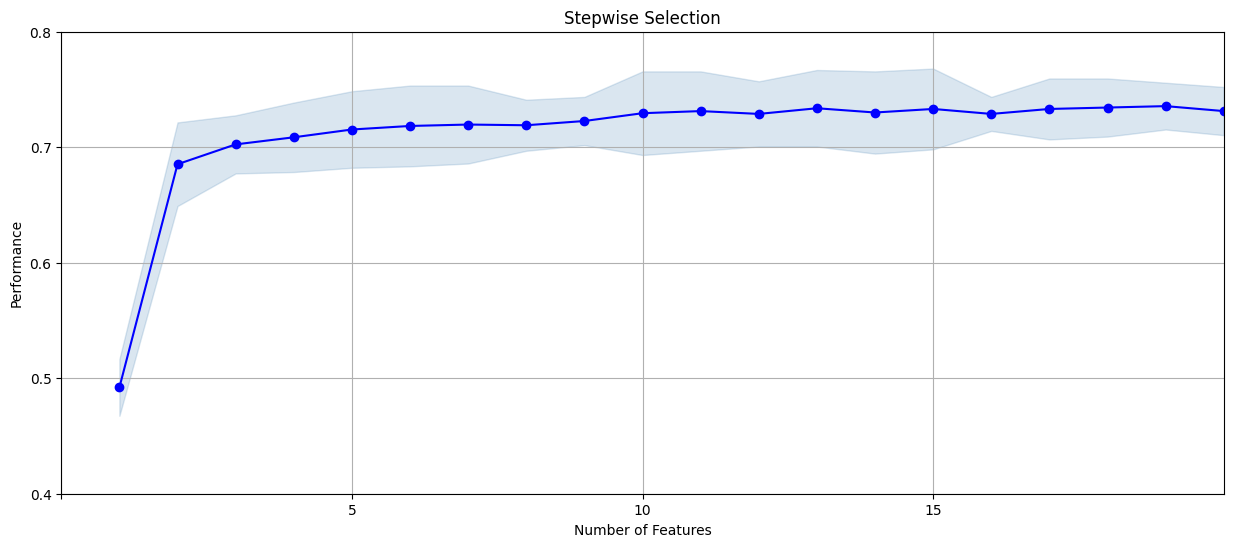

In [21]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
# plt.xticks(np.arange(0, len(X.columns), step=5))
plt.xticks(np.arange(0, num_wrapper, step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([.4,.8])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('performance_nvars.png')
plt.show()

In [22]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [23]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(ordered_vars_FS.loc[i+1,'feature_names'])[0])
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])))[0]

In [24]:
ordered_vars_FS

feature_idx  \
1                                               (21,)   
2                                           (21, 116)   
3                                       (21, 87, 116)   
4                                   (21, 87, 91, 116)   
5                               (21, 69, 87, 91, 116)   
6                           (21, 69, 82, 87, 91, 116)   
7                       (21, 38, 69, 82, 87, 91, 116)   
8                  (21, 38, 69, 82, 87, 91, 116, 143)   
9             (21, 38, 69, 82, 87, 91, 113, 116, 143)   
10       (21, 38, 69, 82, 87, 91, 102, 113, 116, 143)   
11  (21, 38, 69, 82, 87, 91, 102, 113, 116, 120, 143)   
12  (21, 38, 69, 70, 82, 87, 91, 102, 113, 116, 12...   
13  (21, 38, 69, 70, 77, 82, 87, 91, 102, 113, 116...   
14  (21, 38, 69, 70, 77, 82, 87, 91, 102, 104, 113...   
15  (21, 38, 69, 70, 77, 82, 87, 91, 102, 104, 105...   
16  (21, 38, 69, 70, 77, 82, 87, 91, 102, 104, 105...   
17  (21, 38, 69, 70, 77, 82, 87, 91, 102, 104, 105...   
18  (21, 38, 66, 69, 70, 77, 82, 87, 91, 102, 104,...   
19  (21, 38, 66, 69, 70, 77, 81, 82, 87, 91, 102, ...   
20  (21, 38, 65, 66, 69, 70, 77, 81, 82, 87, 91, 1...   

                                    cv_scores avg_score  \
1   [0.5165644171779141, 0.46748466257668714]  0.492025   
2     [0.7214723926380369, 0.649079754601227]  0.685276   
3    [0.7276073619631902, 0.6773006134969325]  0.702454   
4    [0.7386503067484662, 0.6785276073619632]  0.708589   
5    [0.7484662576687117, 0.6822085889570552]  0.715337   
6    [0.7533742331288343, 0.6834355828220859]  0.718405   
7    [0.7533742331288343, 0.6858895705521473]  0.719632   
8    [0.7411042944785277, 0.6969325153374233]  0.719018   
9      [0.743558282208589, 0.701840490797546]  0.722699   
10   [0.7656441717791411, 0.6932515337423313]  0.729448   
11   [0.7656441717791411, 0.6969325153374233]  0.731288   
12   [0.7570552147239263, 0.7006134969325153]  0.728834   
13   [0.7668711656441718, 0.7006134969325153]  0.733742   
14    [0.7656441717791411, 0.694478527607362]  0.730061   
15    [0.7680981595092025, 0.698159509202454]  0.733129   
16    [0.743558282208589, 0.7141104294478527]  0.728834   
17   [0.7595092024539877, 0.7067484662576687]  0.733129   
18   [0.7595092024539877, 0.7092024539877301]  0.734356   
19   [0.7558282208588957, 0.7153374233128834]  0.735583   
20   [0.7521472392638037, 0.7104294478527607]  0.731288   

                                        feature_names  ci_bound   std_dev  \
1            (Cardnum_unique_count_for_card_state_1,)  0.105587   0.02454   
2   (Cardnum_unique_count_for_card_state_1, Card_M...   0.15574  0.036196   
3   (Cardnum_unique_count_for_card_state_1, card_s...  0.108226  0.025153   
4   (Cardnum_unique_count_for_card_state_1, card_s...  0.129344  0.030061   
5   (Cardnum_unique_count_for_card_state_1, Cardnu...  0.142542  0.033129   
6   (Cardnum_unique_count_for_card_state_1, Cardnu...  0.150461  0.034969   
7   (Cardnum_unique_count_for_card_state_1, Cardnu...  0.145182  0.033742   
8   (Cardnum_unique_count_for_card_state_1, Cardnu...  0.095028  0.022086   
9   (Cardnum_unique_count_for_card_state_1, Cardnu...  0.089749  0.020859   
10  (Cardnum_unique_count_for_card_state_1, Cardnu...   0.15574  0.036196   
11  (Cardnum_unique_count_for_card_state_1, Cardnu...  0.147821  0.034356   
12  (Cardnum_unique_count_for_card_state_1, Cardnu...  0.121425  0.028221   
13  (Cardnum_unique_count_for_card_state_1, Cardnu...  0.142542  0.033129   
14  (Cardnum_unique_count_for_card_state_1, Cardnu...  0.153101  0.035583   
15  (Cardnum_unique_count_for_card_state_1, Cardnu...  0.150461  0.034969   
16  (Cardnum_unique_count_for_card_state_1, Cardnu...  0.063352  0.014724   
17  (Cardnum_unique_count_for_card_state_1, Cardnu...  0.113506   0.02638   
18  (Cardnum_unique_count_for_card_state_1, Cardnu...  0.108226  0.025153   
19  (Cardnum_unique_count_for_card_state_1, Cardnu...  0.087109  0.020245   
20  (Cardnum_unique_count_for_card_state_1, Cardnu...  0.089749 

In [25]:
ordered_vars_FS.to_csv('Wrapper_selection_info.csv', index=False)

In [26]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('final_vars_list.csv',index=False)
vars_keep

1        Cardnum_unique_count_for_card_state_1
2                       Card_Merchdesc_total_3
3                             card_state_max_3
4                             card_state_max_1
5                        Cardnum_vdratio_0by14
6                        Card_dow_actual/max_7
7                             Cardnum_count_14
8                            card_state_max_14
9     Card_dow_unique_count_for_merch_state_60
10                         card_merch_total_14
11                    Cardnum_count_0_by_60_sq
12      Card_dow_unique_count_for_state_des_14
13                               Cardnum_avg_0
14                              Card_dow_avg_7
15                            card_zip_total_7
16                         merch_state_total_1
17                            Merchnum_total_1
18                      Card_dow_actual/toal_7
19                               Cardnum_avg_1
20                           Card_dow_count_30
Name: variable name, dtype: object

In [27]:
filter_score.set_index('variable',drop=True,inplace=True)
filter_score = filter_score.iloc[1:,:]
filter_score

filter score
variable                                               
Cardnum_total_3                                0.621932
Cardnum_total_1                                0.619658
Cardnum_total_0                                0.591318
Cardnum_count_1                                0.567429
Cardnum_total_7                                0.564245
...                                                 ...
card_merch_unique_count_for_card_state_7       0.000088
card_merch_unique_count_for_card_state_3       0.000063
merch_zip_unique_count_for_merch_state_14      0.000025
merch_zip_unique_count_for_merch_state_7       0.000013
card_merch_unique_count_for_Cardnum_1          0.000000

[1329 rows x 1 columns]

In [28]:
vars_keep_sorted = pd.DataFrame(vars_keep_list)
vars_keep_sorted.columns=['variable']
vars_keep_sorted.set_index('variable',drop=True,inplace=True)
vars_keep_sorted.head()

Empty DataFrame
Columns: []
Index: [Cardnum_unique_count_for_card_state_1, Card_Merchdesc_total_3, card_state_max_3, card_state_max_1, Cardnum_vdratio_0by14]

In [29]:
vars_keep_sorted = pd.concat([vars_keep_sorted,filter_score],axis=1,join='inner')

In [30]:
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted['index'] = vars_keep_sorted['index'] + 1
vars_keep_sorted.rename(columns={'index':'wrapper order'},inplace=True)
vars_keep_sorted.to_csv('vars_keep_sorted.csv',index=False)
vars_keep_sorted

wrapper order                                  variable  filter score
0               1     Cardnum_unique_count_for_card_state_1      0.476067
1               2                    Card_Merchdesc_total_3      0.319675
2               3                          card_state_max_3      0.341323
3               4                          card_state_max_1      0.334797
4               5                     Cardnum_vdratio_0by14      0.379037
5               6                     Card_dow_actual/max_7      0.349000
6               7                          Cardnum_count_14      0.445443
7               8                         card_state_max_14      0.305946
8               9  Card_dow_unique_count_for_merch_state_60      0.320580
9              10                       card_merch_total_14      0.329023
10             11                  Cardnum_count_0_by_60_sq      0.317871
11             12    Card_dow_unique_count_for_state_des_14      0.374334
12             13                             Cardnum_avg_0      0.363150
13             14                            Card_dow_avg_7      0.326091
14             15                          card_zip_total_7      0.325807
15             16                       merch_state_total_1      0.304893
16             17                          Merchnum_total_1      0.304868
17             18                    Card_dow_actual/toal_7      0.389288
18             19                             Cardnum_avg_1      0.352529
19             20                         Card_dow_count_30      0.390454

In [31]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list

['Cardnum_unique_count_for_card_state_1',
 'Card_Merchdesc_total_3',
 'card_state_max_3',
 'card_state_max_1',
 'Cardnum_vdratio_0by14',
 'Card_dow_actual/max_7',
 'Cardnum_count_14',
 'card_state_max_14',
 'Card_dow_unique_count_for_merch_state_60',
 'card_merch_total_14',
 'Cardnum_count_0_by_60_sq',
 'Card_dow_unique_count_for_state_des_14',
 'Cardnum_avg_0',
 'Card_dow_avg_7',
 'card_zip_total_7',
 'merch_state_total_1',
 'Merchnum_total_1',
 'Card_dow_actual/toal_7',
 'Cardnum_avg_1',
 'Card_dow_count_30',
 'Recnum',
 'Fraud']

In [32]:
filter_score

filter score
variable                                               
Cardnum_total_3                                0.621932
Cardnum_total_1                                0.619658
Cardnum_total_0                                0.591318
Cardnum_count_1                                0.567429
Cardnum_total_7                                0.564245
...                                                 ...
card_merch_unique_count_for_card_state_7       0.000088
card_merch_unique_count_for_card_state_3       0.000063
merch_zip_unique_count_for_merch_state_14      0.000025
merch_zip_unique_count_for_merch_state_7       0.000013
card_merch_unique_count_for_Cardnum_1          0.000000

[1329 rows x 1 columns]

In [33]:
%%time
df = pd.read_csv(file_name)
df.shape

CPU times: user 11.1 s, sys: 1.41 s, total: 12.5 s
Wall time: 12.8 s


(97496, 1330)

In [34]:
df_keep = df.filter(vars_keep_list, axis=1)
# df_keep = df[df.index.isin(vars_keep_list)]
print(df_keep.shape)

(97496, 22)


In [35]:
df_keep.to_csv('vars_final.csv',index=False)

In [36]:
print("duration: ", dt.datetime.now() - start_time)

duration:  0:56:10.929912
